In [1]:
import BioSimSpace as BSS

INFO:rdkit:Enabling RDKit 2023.03.3 jupyter extensions


In [29]:
#loading GROMACS files 
files = ["input_files/compound_19.gro", "input_files/compound_19.top"]
comp_19_esp = BSS.IO.readMolecules(files)

In [30]:
print(comp_19_esp.nAtoms())

176


In [31]:
#Solvation with tip3p water  

# Get the minimium and maximum coordinates of the bounding box that
# minimally encloses the protein.
box_min, box_max = comp_19_esp.getAxisAlignedBoundingBox()

# Work out the box size from the difference in the coordinates.
box_size = [y - x for x, y in zip(box_min, box_max)]

# How much to pad each side of the protein? (Nonbonded cutoff = 10 A)
padding = 15 * BSS.Units.Length.angstrom

# Work out an appropriate box. This will used in each dimension to ensure
# that the cutoff constraints are satisfied if the molecule rotates.
box_length = max(box_size) + 2 * padding

#solvation in box
solvated = BSS.Solvent.tip3p(molecule=comp_19_esp, box=3 * [box_length])

In [32]:
#viewing the slvated system
view = BSS.Notebook.View(solvated)
view.system()

NGLWidget(gui_style='ngl')

In [33]:
#minimisation
protocol = BSS.Protocol.Minimisation(steps=5000)
process= BSS.Process.Amber(solvated, protocol,  exe='/usr/local/amber22_test/bin/pmemd.cuda')
process.start()
print(process.getTotalEnergy(block=True))

-4.1887e+04 kcal/mol


In [34]:
minimised = process.getSystem(block=True)

In [35]:
#equilibration
protocol= BSS.Protocol.Equilibration(runtime = 0.2 * BSS.Units.Time.nanosecond)
process = BSS.Process.Amber(minimised, protocol, exe='/usr/local/amber22_test/bin/pmemd.cuda', work_dir='equib_100')
process
process.start()
equilibrated = process.getSystem(block=True)

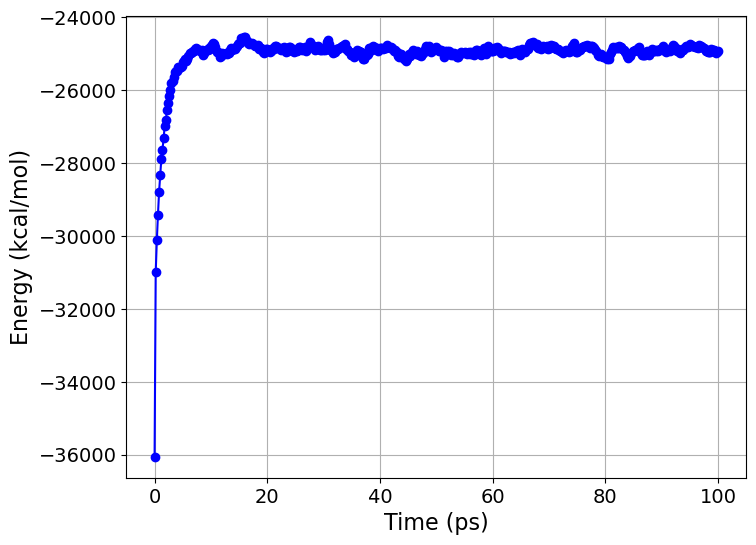

In [36]:
#just in case:
#process.kill()
plot = BSS.Notebook.plot(process.getTime(time_series=True), process.getTotalEnergy(time_series=True))

In [37]:
#collecting the data for 1000 ns
protocol = BSS.Protocol.Production(timestep=2.0000 * BSS.Units.Time.femtosecond, runtime= 1000 * BSS.Units.Time.nanosecond, report_interval = 5000, restart_interval=12500)
process = BSS.Process.Amber(equilibrated, protocol, exe='/usr/local/amber22_test/bin/pmemd.cuda', work_dir='prod_1000ns_40000_3')
#process.start()

In [ ]:
#use set-up files by BSS to run slurm script for data production